In [23]:
import numpy as np
import pandas as pd
import extinction
from astropy.io import fits
from astropy.table import Table
from helper import phys
from helper.specread import get_keck, gaplinelist
from helper.readfilter import get_UVOT_eff_wave, get_SDSS_eff_wave, get_PS1_eff_wave, get_2MASS_eff_wave, get_WISE_eff_wave
from helper.specread import add_telluric_circle, pblines
from helper.specread import truncate_spec, measure_flux, gaus
from helper.app2abs import add_physcol, deredden_df, app2abs_df
from allsn_info import get_at2019dge
from scipy.interpolate import splrep, splev, interp1d

import matplotlib
import matplotlib.pyplot as plt
fs= 14
matplotlib.rcParams['font.size']=fs

%matplotlib notebook

In [2]:
result = get_at2019dge()
z = result["z"]
ebv = result["ebv"]
ebv = result["ebv"]
t_max = result["t_max"]

In [3]:
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const
cosmo = FlatLambdaCDM(H0=70., Om0=0.275)
D = cosmo.luminosity_distance([0.0213])[0].value * 1e+6 # in pc

filter response functions are from http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=2MASS

In [4]:
wvU, xU, yU = get_UVOT_eff_wave("Swift_UVOT.U.dat", return_type = 'more')
wvB, xB, yB = get_UVOT_eff_wave("Swift_UVOT.B.dat", return_type = 'more')
wvV, xV, yV = get_UVOT_eff_wave("Swift_UVOT.V.dat", return_type = 'more')
wvUW1, xUVW1, yUVW1 = get_UVOT_eff_wave("Swift_UVOT.UVW1.dat", return_type = 'more')
wvUW2, xUVW2, yUVW2 = get_UVOT_eff_wave("Swift_UVOT.UVW2.dat", return_type = 'more')
wvUM2, xUVM2, yUVM2 = get_UVOT_eff_wave("Swift_UVOT.UVM2.dat", return_type = 'more')
print ("%.1f %.1f %.1f %.1f %.1f %.1f"%(wvUW2, wvUM2, wvUW1, wvU, wvB, wvV))

2079.0 2255.1 2614.2 3475.5 4359.1 5430.1


In [5]:
wvu, _, _ = get_SDSS_eff_wave(ext=1)
wvg, _, _ = get_SDSS_eff_wave(ext=2)
wvr, _, _ = get_SDSS_eff_wave(ext=3)
wvi, _, _ = get_SDSS_eff_wave(ext=4)
wvz, _, _ = get_SDSS_eff_wave(ext=5)
print ("%.1f %.1f %.1f %.1f %.1f"%(wvu, wvg, wvr, wvi, wvz))

3561.8 4718.9 6185.2 7499.7 8961.5


In [6]:
wvpsg, _, _ = get_PS1_eff_wave(myfilter="g")
wvpsr, _, _ = get_PS1_eff_wave(myfilter="r")
wvpsi, _, _ = get_PS1_eff_wave(myfilter="i")
wvpsz, _, _ = get_PS1_eff_wave(myfilter="z")
wvpsy, _, _ = get_PS1_eff_wave(myfilter="y")
print ("%.1f %.1f %.1f %.1f %.1f"%(wvpsg, wvpsr, wvpsi, wvpsz, wvpsy))

4866.5 6214.6 7544.6 8679.5 9633.3


In [7]:
wvJ, _, _ = get_2MASS_eff_wave(myfilter="J")
wvH, _, _ = get_2MASS_eff_wave(myfilter="H")
print ("%.1f %.1f"%(wvJ, wvH))

12410.5 16513.7


In [8]:
wvW1, _, _ = get_WISE_eff_wave(myfilter="W1")
wvW2, _, _ = get_WISE_eff_wave(myfilter="W2")
print ("%.1f %.1f"%(wvW1, wvW2))

34002.6 46520.1


In [18]:
mags = [20.492, 20.471, 20.081, 19.631, 18.812, 18.194, # UVOT
        19.636, 18.540, 18.056, 17.885, 17.697, # SDSS 
        18.538, 18.029, 17.845, 17.755, 17.710, # PS1
        17.653, 17.690, # 2MASS
        18.460, 18.953  # WISE
       ]
emags = [0.124, 0.172, 0.155, 0.145, 0.139, 0.171, # UVOT
         0.082, 0.015, 0.026, 0.028, 0.089, #SDSS 
         0.042, 0.030, 0.033, 0.050, 0.063, # PS1
         0.215, 0.420, # 2MASS
         0.069, 0.136  # WISE
        ]

waves = [wvUW2, wvUM2, wvUW1, wvU, wvB, wvV, # UVOT
         wvu, wvg, wvr, wvi, wvz, # SDSS
         wvpsg, wvpsr, wvpsi, wvpsz, wvpsy, # PS1
         wvJ, wvH, # 2MASS
         wvW1, wvW2 # WISE
        ]

instruments = ["UVOT", "UVOT", "UVOT", "UVOT", "UVOT", "UVOT",
               "SDSS", "SDSS", "SDSS", "SDSS", "SDSS",
               "PS1", "PS1","PS1","PS1","PS1",
               "2MASS", "2MASS", 
               "WISE", "WISE"
              ]
d = {'mag': mags, 'emag': emags, "wave": waves, "instrument": instruments}
df = pd.DataFrame(data=d)

df["freq"] = phys.c / (df['wave'].values * 1e-8)

In [19]:
df = deredden_df(df, ebv = ebv)
df = app2abs_df(df, z=z)
df = add_physcol(df, magcol = "mag")

In [20]:
df.to_csv("../data/photometry/host/phot_host.csv")

<IPython.core.display.Javascript object>


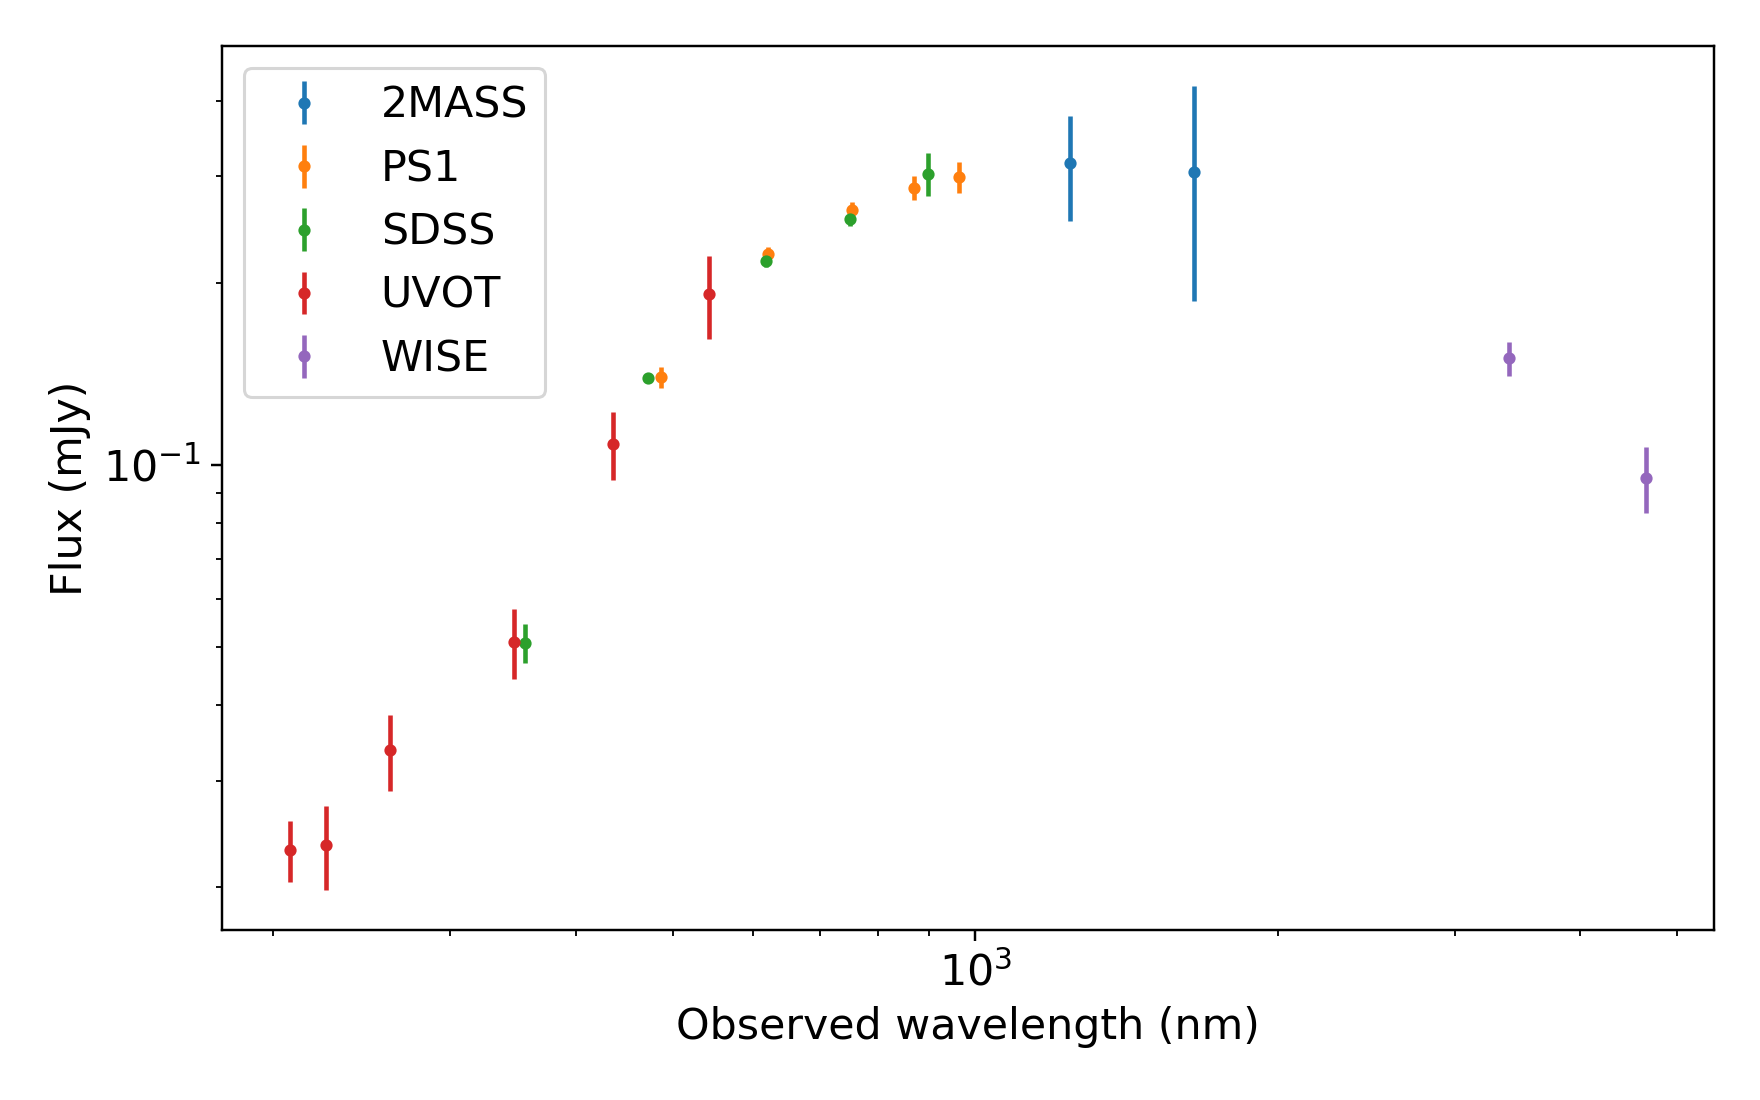

In [29]:
insts = np.unique(df["instrument"].values)

plt.figure(figsize=(8,5))
axi = plt.subplot(111)
for inst in insts:
    ix = df["instrument"].values == inst
    axi.errorbar(df["wave"].values[ix]/10, df["fnu"].values[ix]*1e26, df["fnu_unc"].values[ix]*1e26, fmt=".", label = inst)
#plt.plot(2.3e+11, 750,  "o", marker='v',color='k')
#plt.plot(3.45e+11, 2800, "o", marker='v',color='k')
plt.legend()
#plt.xlim(1e+11, 2e+11)
plt.semilogy()
plt.semilogx()
axi.set_xlabel("Observed wavelength (nm)")
axi.set_ylabel("Flux (mJy)")
plt.tight_layout()

In [31]:
df.head()

,mag,emag,wave,instrument,freq,mag0,mag0_abs,fratio,fratio_unc,fnu,fnu_unc,nufnu,nufnu_unc,flambda,flambda_unc,Llambda,Llambda_unc
0,20.492,0.124,2079.033684,UVOT,1.441980e+15,20.281991,-14.554676,6.356236e-09,7.259344e-10,2.307949e-28,2.635868e-29,3.328016e-13,3.800868e-14,1.600751e-16,1.828190e-17,1.915291e+24,2.187420e+23
1,20.471,0.172,2255.077725,UVOT,1.329411e+15,20.265704,-14.570962,6.480373e-09,1.026607e-09,2.353023e-28,3.727609e-29,3.128135e-13,4.955524e-14,1.387152e-16,2.197496e-17,1.659720e+24,2.629293e+23
2,20.081,0.155,2614.221271,UVOT,1.146775e+15,19.935418,-14.901248,9.281112e-09,1.324974e-09,3.369972e-28,4.810981e-29,3.864601e-13,5.517114e-14,1.478299e-16,2.110424e-17,1.768778e+24,2.525112e+23
3,19.631,0.145,3475.494702,UVOT,8.625893e+14,19.522024,-15.314642,1.404753e-08,1.876047e-09,5.100659e-28,6.811926e-29,4.399774e-13,5.875895e-14,1.265942e-16,1.690664e-17,1.514693e+24,2.022872e+23
4,18.812,0.139,4359.055837,UVOT,6.877463e+14,18.720641,-16.116025,2.986758e-08,3.823759e-09,1.084492e-27,1.388407e-28,7.458552e-13,9.548717e-14,1.711048e-16,2.190547e-17,2.047260e+24,2.620979e+23
